# Fraud Detection

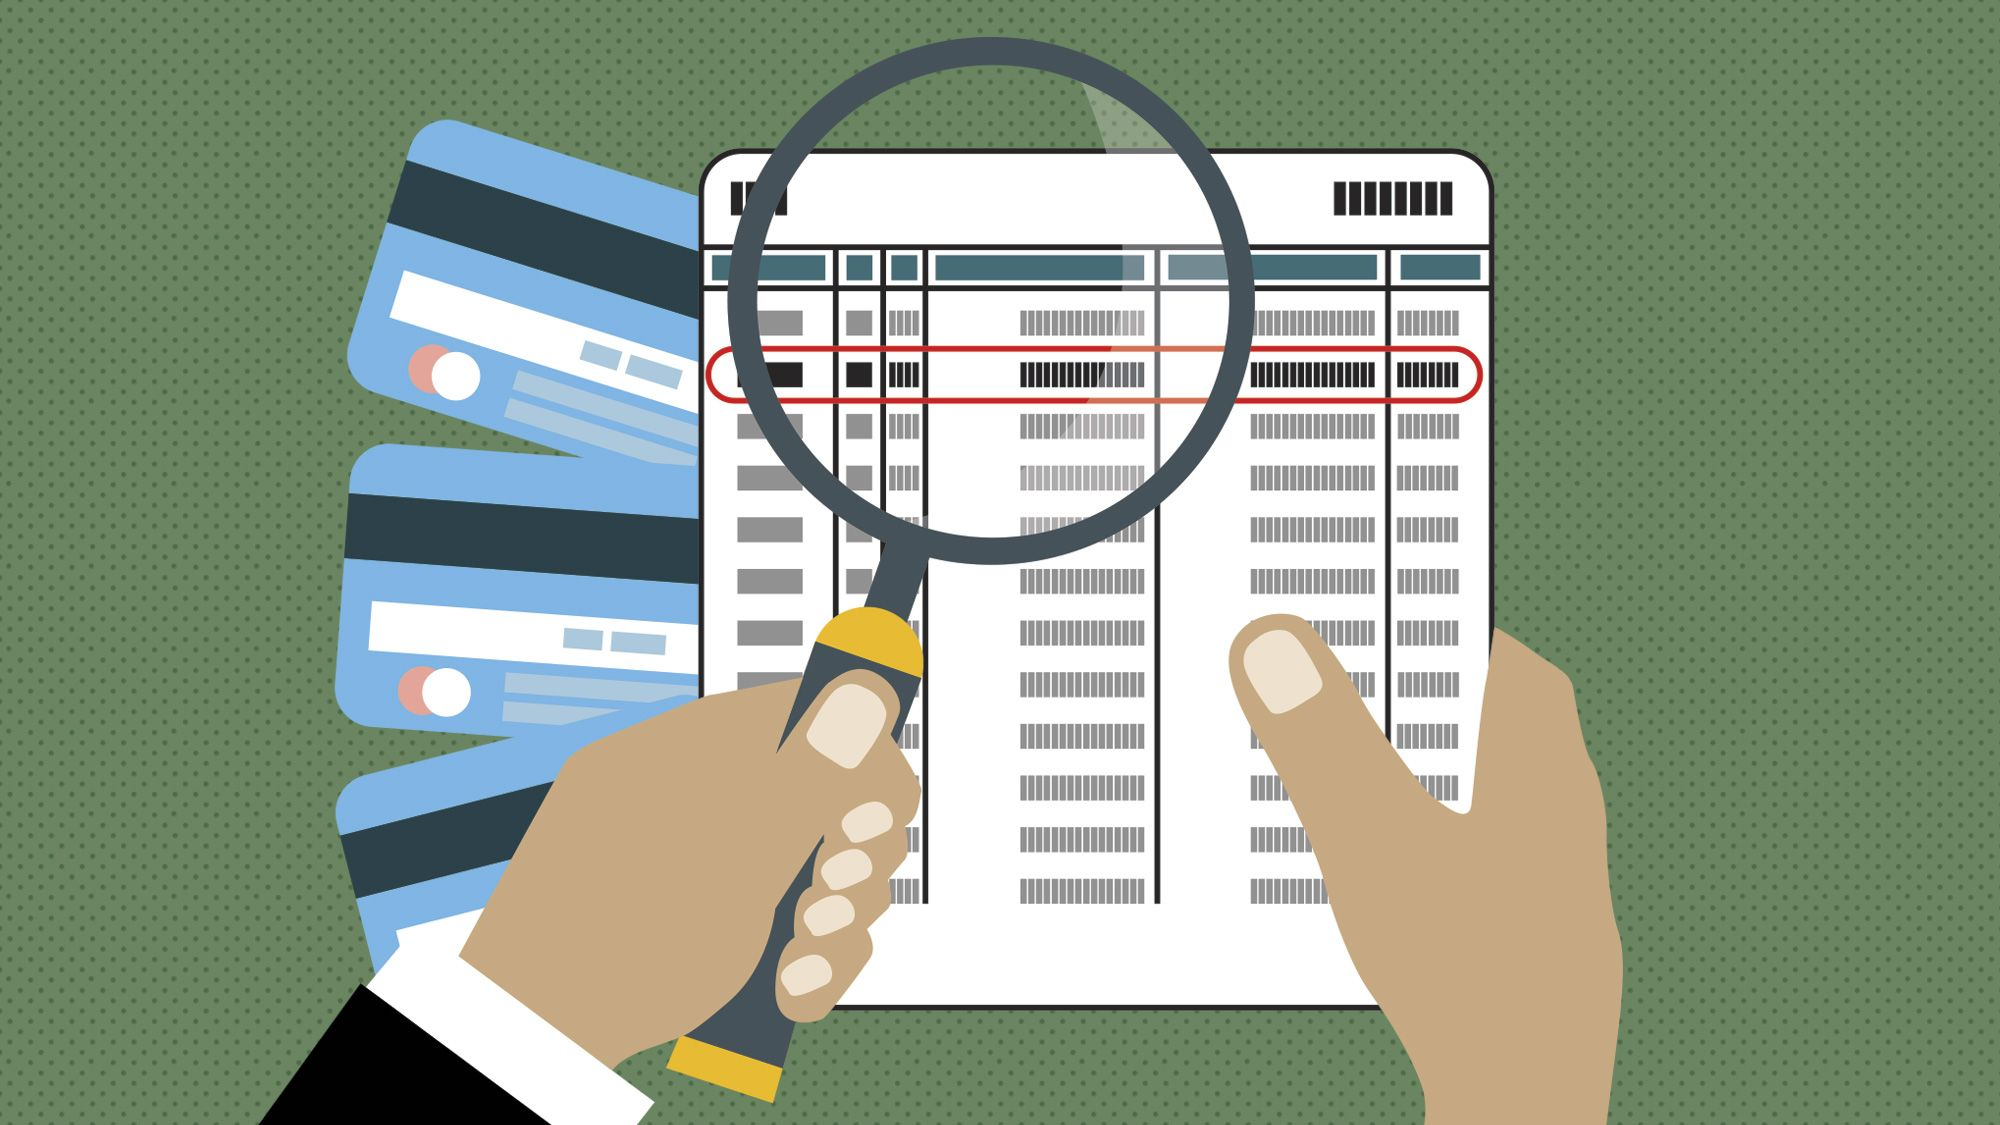

This project aims to build the most accurate model that will help find fraud in data. For this we will use data from Kaggle. We will conduct exploratory data analysis, after which we will prepare a dataset, create basic models and compare their results

First, we import all the libraries that will be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from xgboost import XGBClassifier

from xgboost import plot_importance

Next, we load the dataset itself

In [2]:
df = pd.read_csv('C:\PytonDataSets\card_transdata.csv', encoding='utf-8')

# EDA

Now we can start the analysis process, for a start it is worth getting acquainted with the available data

In [3]:
df.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


distance_from_home - the distance from home where the transaction happened.

distance_from_last_transaction - the distance from last transaction happened.

ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.

repeat_retailer - Is the transaction happened from same retailer.

used_chip - Is the transaction through chip (credit card).

used_pin_number - Is the transaction happened by using PIN number.

online_order - Is the transaction an online order.

fraud - Is the transaction fraudulent.

Next, we will define the available data types and review the general information about the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


All of our data is of type. Now we can make sure that we don't have zero values

In [5]:
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

We can also familiarize ourselves with the basic descriptive statistics

In [6]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


According to some minimum and maximum values, we can already assume that we have outliers. We are most interested in the "fraud" column, it takes two values 0 - no fraud and 1 - there is fraud, so we can compare the main parameters between these values

In [7]:
mean_fraud = df.groupby(['fraud'])[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer']].agg(['mean', 'std'])
mean_fraud

distance_from_home             distance_from_last_transaction  \
                    mean         std                           mean   
fraud                                                                 
0.0            22.832976   52.828655                       4.301391   
1.0            66.261876  134.391608                      12.712185   

                 ratio_to_median_purchase_price           repeat_retailer  \
             std                           mean       std            mean   
fraud                                                                       
0.0    22.472359                       1.423642  1.946152        0.881672   
1.0    47.997697                       6.006323  5.564320        0.880119   

                 
            std  
fraud            
0.0    0.322997  
1.0    0.324825

Indeed, we see about a 2-3x difference between some metrics, so there is a difference. Next, we will build a correlation matrix, it will help us find whether there is a large interaction between certain indicators

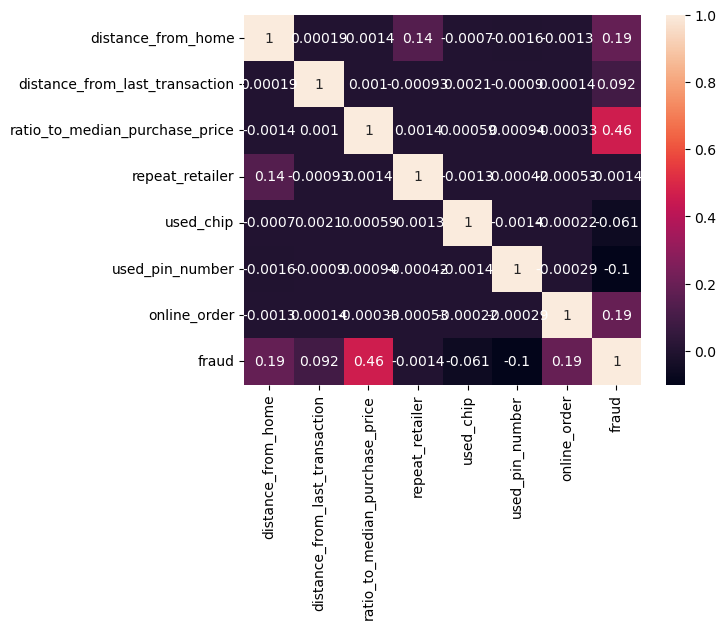

In [8]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

There is a noticeable but not very large correlation between our target bar and the ratio to the median purchase price

In [9]:
num_of_observations = df.shape[0] 
print(f'In original dataset we have {num_of_observations} observations')

In original dataset we have 1000000 observations


But is our data balanced? Balance plays an important role in many models, so it is better to check the relationship between our target values

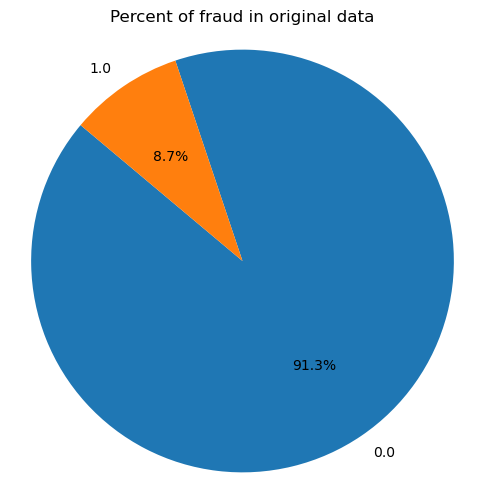

In [10]:
fraud_counts = df['fraud'].value_counts(normalize=True)

labels = fraud_counts.index
sizes = fraud_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percent of fraud in original data')
plt.axis('equal')
plt.show()

Our data is not balanced, many more transactions did not contain fraud, so something needs to be done about it

In [11]:
no_fraud = df[df['fraud'] == 0.0]
fraud = df[df['fraud'] == 1.0]

We have two options, 1 is to reduce the number of dominant observations, 2 is to artificially increase the number of non-dominant ones. In this case, given that we have 1000000 observations, we can use the first option.

In [12]:
down = resample(no_fraud,
             replace=True,
             n_samples=len(fraud),
             random_state=42)

df_ds = pd.concat([down, fraud])

In [13]:
df_ds = df_ds.reset_index(drop=True).drop_duplicates()
df_ds

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,11.142906,1.707915,3.258580,1.0,0.0,0.0,1.0,0.0
1,9.716696,0.295794,0.975820,1.0,0.0,0.0,1.0,0.0
2,34.705677,4.387075,1.084406,1.0,0.0,0.0,0.0,0.0
3,4.185739,0.410359,0.673938,1.0,1.0,0.0,0.0,0.0
4,4.763451,14.888015,1.373116,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
174801,45.296658,0.882736,8.856861,1.0,0.0,0.0,1.0,1.0
174802,167.139756,0.282253,0.308468,1.0,0.0,0.0,1.0,1.0
174803,124.640118,0.004416,0.434885,1.0,0.0,0.0,1.0,1.0
174804,51.412900,3.429330,29.914254,1.0,0.0,0.0,1.0,1.0


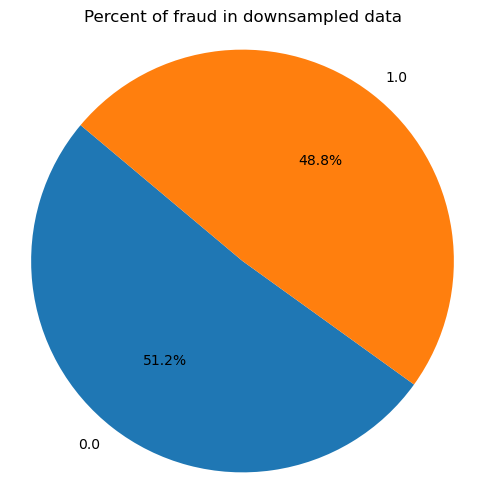

In [14]:
fraud_counts2 = df_ds['fraud'].value_counts(normalize=True)

labels2 = fraud_counts2.index
sizes2 = fraud_counts2.values

plt.figure(figsize=(6, 6))
plt.pie(sizes2, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percent of fraud in downsampled data')
plt.axis('equal')
plt.show()

Now, as you can see in the diagram, we have balanced data, we also removed duplicates and now the dataset is ready to use

In [15]:
num_of_observations2 = df_ds.shape[0] 
saved = num_of_observations2/num_of_observations*100

print(f'In downsampled dataset we have {num_of_observations2} observations')
print(f'We have {saved} % of original data')

In downsampled dataset we have 170777 observations
We have 17.0777 % of original data


But also, as we saw in the descriptive statistics, we probably have outliers, that's also worth checking. Some models are not sensitive to emissions, and some are the other way around.

In [16]:
def find_outliers(df, column_name):
    percentile25 = df[column_name].quantile(0.25)
    percentile75 = df[column_name].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    outliers = df[(df[column_name] > upper_limit) | (df[column_name] < lower_limit)]
    percentage_of_outliers = len(outliers) / len(df[column_name]) * 100
    print(f"\nOutlies data in {column_name}:")
    print("Lower limit:", lower_limit)
    print("Upper limit:", upper_limit)
    print("Percent of rows in the data containing outliers in '{}': {:.2f}%".format(column_name, percentage_of_outliers))
    return outliers

outliers = find_outliers(df_ds, 'ratio_to_median_purchase_price')
outliers = find_outliers(df_ds, 'distance_from_last_transaction')
outliers = find_outliers(df_ds, 'distance_from_home')


Outlies data in ratio_to_median_purchase_price:
Lower limit: -6.197192284175838
Upper limit: 12.185503466968932
Percent of rows in the data containing outliers in 'ratio_to_median_purchase_price': 4.41%

Outlies data in distance_from_last_transaction:
Lower limit: -5.035395992950756
Upper limit: 9.224683434003605
Percent of rows in the data containing outliers in 'distance_from_last_transaction': 13.71%

Outlies data in distance_from_home:
Lower limit: -46.93609280910504
Upper limit: 89.26579802523031
Percent of rows in the data containing outliers in 'distance_from_home': 15.21%


As we can see, some columns contain 13-15% of outliers. The last step will be to split our data into training and test data. Training - for training the model, test - for checking it. The main ones will be ordinary x and y. While x2 and y2 only for comparison, they will use unbalanced data.

In [17]:
X = df_ds.drop(columns=['fraud'])
y = df_ds['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.25, random_state=42)

X2 = df.drop(columns=['fraud'])
y2 = df['fraud']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2,
                                              test_size=0.25, random_state=42)

# Logistic Regression

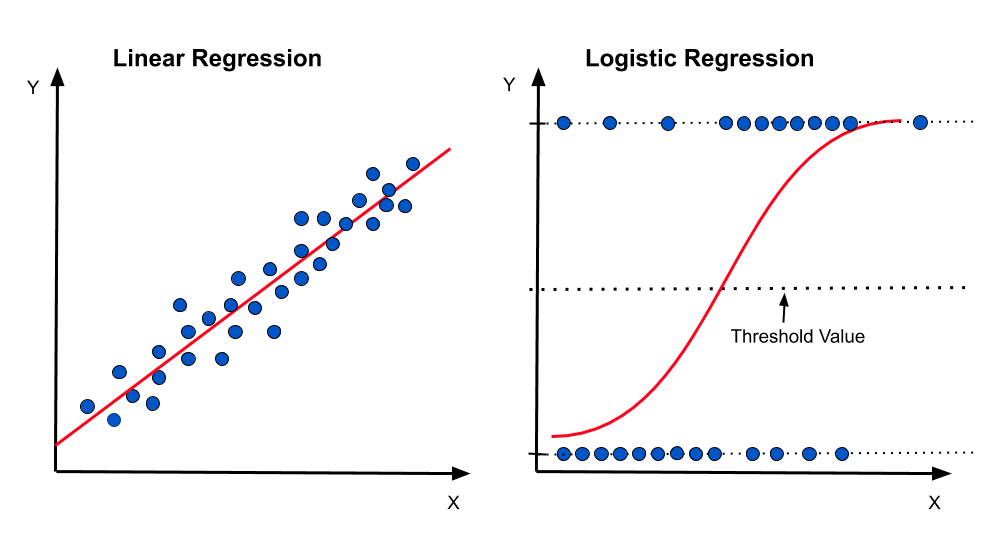

First, we will use logistic regression and immediately check for unbalanced data

In [18]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X_train,y_train)
lr2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X2_train,y2_train)

In [19]:
y_pred_lr = lr.predict(X_test)
y_pred_lr2 = lr2.predict(X2_test)

And so, having predictions of logistic regression, we can estimate the result. Our main metric will be recall, as it is most important for us to find all fraudulent transactions and not so critical if, for example, a normal transaction is identified as fraudulent

In [20]:
print("Downsampled data Logistic Regression scores:")
print("Accuracy:", "%.6f" % accuracy_score(y_test, y_pred_lr))
print("Precision:", "%.6f" % precision_score(y_test, y_pred_lr))
print("Recall:", "%.6f" % recall_score(y_test, y_pred_lr))
print("F1 Score:", "%.6f" % f1_score(y_test, y_pred_lr))

print("\nOriginal data Logistic Regression scores:")
print("Accuracy:", "%.6f" % accuracy_score(y2_test, y_pred_lr2))
print("Precision:", "%.6f" % precision_score(y2_test, y_pred_lr2))
print("Recall:", "%.6f" % recall_score(y2_test, y_pred_lr2))
print("F1 Score:", "%.6f" % f1_score(y2_test, y_pred_lr2))

Downsampled data Logistic Regression scores:
Accuracy: 0.942359
Precision: 0.934948
Recall: 0.953732
F1 Score: 0.944247

Original data Logistic Regression scores:
Accuracy: 0.959236
Precision: 0.897952
Recall: 0.602032
F1 Score: 0.720802


Our metrics are pretty good, especially the difference between the metrics on balanced and unbalanced data is worth paying attention to, that's why it's always worth paying attention to

In [21]:
def get_test_scores(model_name:str, preds, y_test_data):

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

Next, we built a function that creates a dataset with our indicators, as our project progresses, we will fill this table

In [22]:
results = get_test_scores('Logistic Regression', y_pred_lr, y_test)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359


we have a fairly high recall rate, so overall the model works pretty well, but it's worth comparing it to others. The following matrix from the top left shows truly fraudulent transactions, from the top right those that were identified as fraudulent but actually normal, from the bottom left - those that were identified as normal but actually fraudulent, from the bottom right - those that were correctly identified as normal

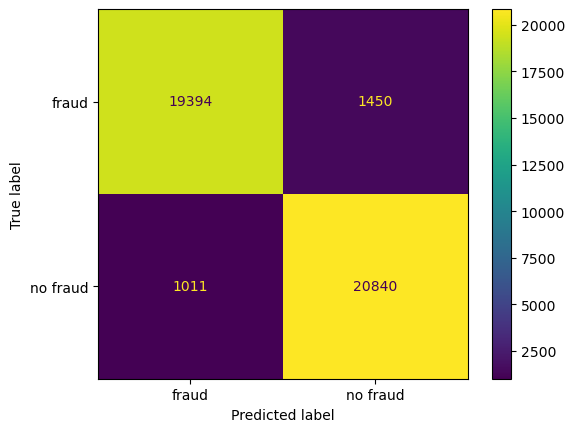

In [23]:
cm = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fraud', 'no fraud'])
disp.plot();

# Naive Bayes

The Naive Bayes model is a statistical machine learning algorithm based on Bayes' theorem. It uses a simplified assumption of "naiveness", i.e. it assumes that all signs are independent of each other, which allows to simplify calculations.

Advantages of the Naive Bayes model:

Simplicity and efficiency: The model is easy to implement and works efficiently even on large data sets.

Learning speed: Naive Bayes can learn quickly on large amounts of data because it does not require complex iterations or hyperparameter tuning.

Performance with a large number of features: Performs well even with a large number of features, making it applicable to text analysis and email classification.

Excellent at working with categorical data: Naive Bayes is particularly effective when working with categorical features such as words in text.

It is worth noting that the naive assumption of independence may not be valid in real situations, but regardless, the model can work well in many cases.

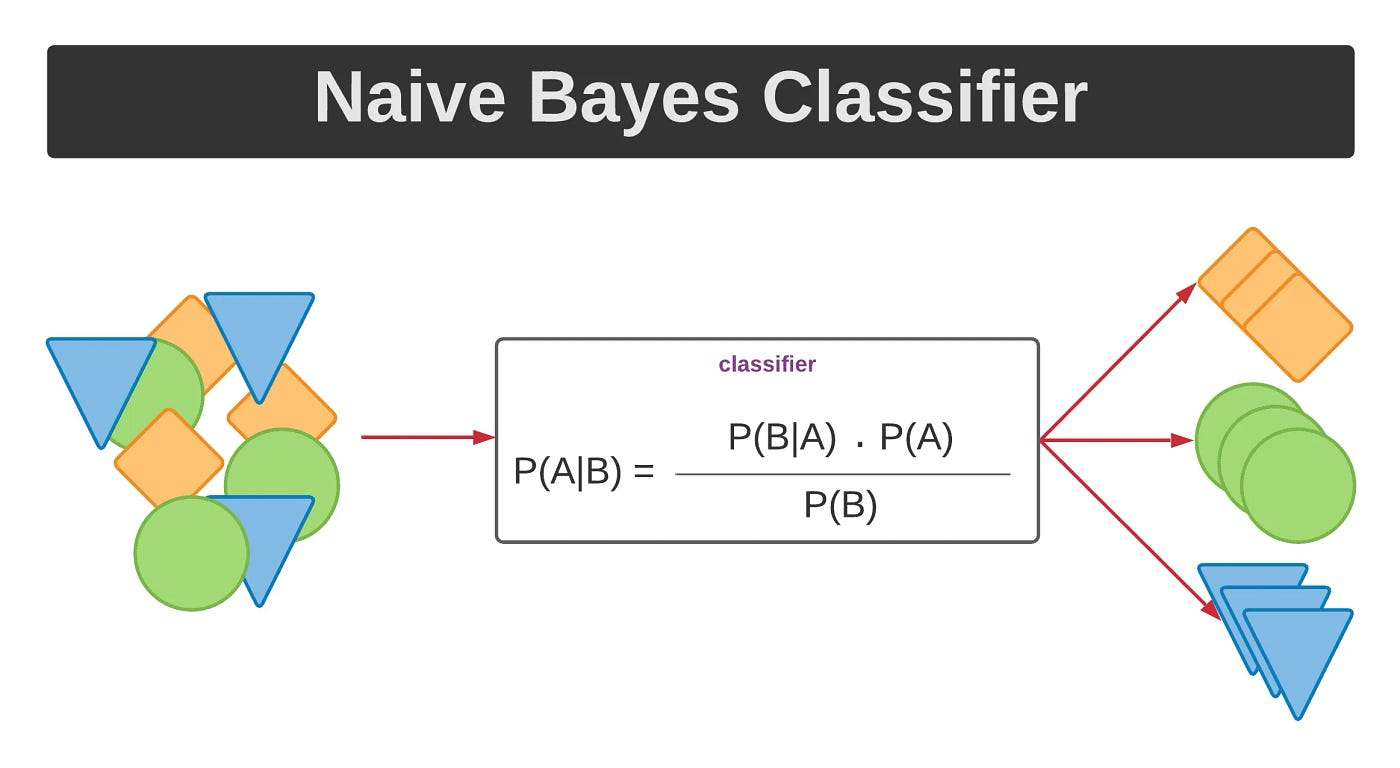

In [24]:
nb = naive_bayes.GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_test)

In [25]:
nb_scores = get_test_scores('Naive Bayes', y_nb, y_test)

results = pd.concat([results, nb_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359
0,Naive Bayes,0.907433,0.963205,0.934488,0.930882


As you can see from the results, recall is slightly higher, while other indicators are worse than the previous model

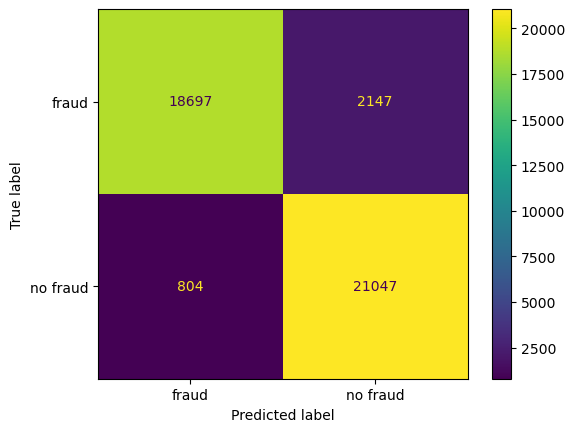

In [26]:
cm = confusion_matrix(y_test, y_nb, labels=nb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fraud', 'no fraud'])
disp.plot();

# Decision Tree

Next is the decision tree model, which often performs better than previous models. The evaluation methods are the same, the model itself works more slowly.

The process of building a decision tree involves selecting the most informative attributes to partition the data and building decision rules based on these attributes. Node splitting continues until satisfactory model quality is achieved or certain stopping criteria are met.

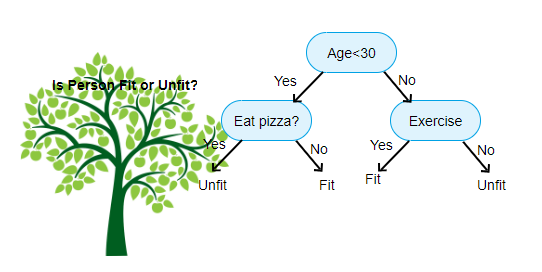

In [27]:
tree = DecisionTreeClassifier(random_state=0)

cv_params = {'max_depth':[4, 6, 8, 10, 15, None],
             'min_samples_leaf': [2, 5, 1, 7],
             'min_samples_split': [1, 2, 4, 6]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

dt = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='recall')

In [28]:
dt.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, 10, 15, None],
                         'min_samples_leaf': [2, 5, 1, 7],
                         'min_samples_split': [1, 2, 4, 6]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

In [29]:
dt.best_score_

0.9999389797412741

In [30]:
dt.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 1}

In [31]:
y_tree = dt.predict(X_test)

In [32]:
dt_scores = get_test_scores('Decision Tree', y_tree, y_test)

results = pd.concat([results, dt_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359
0,Naive Bayes,0.907433,0.963205,0.934488,0.930882
0,Decision Tree,0.999725,0.999863,0.999794,0.999789


And indeed, the model produces fantastic results and works very well, recall is close to 100%. Next, we can determine which factors most influence this prediction.

In [33]:
dt_importances = pd.DataFrame(dt.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
dt_importances = dt_importances.sort_values(by='gini_importance', ascending=False)

dt_importances = dt_importances[dt_importances['gini_importance'] != 0]
dt_importances

,gini_importance
ratio_to_median_purchase_price,0.512152
distance_from_home,0.288130
distance_from_last_transaction,0.112618
online_order,0.053240
used_chip,0.020333
used_pin_number,0.013527


And we can observe that the same indicator that is highly correlated with fraud is the most important in predicting.

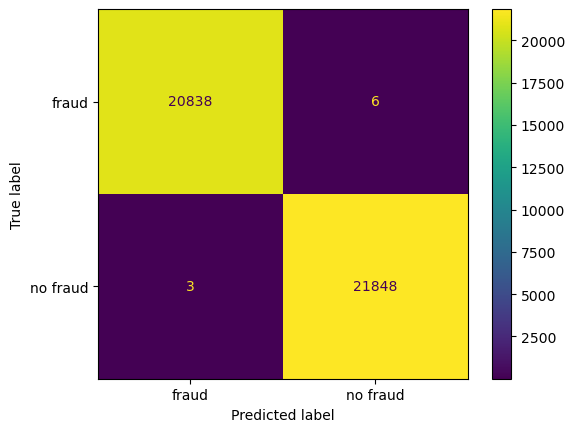

In [34]:
cm = confusion_matrix(y_test, y_tree, labels=dt.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fraud', 'no fraud'])
disp.plot();

only 3 values were not identified as fraudulent

# XGBoost

XGBoost (eXtreme Gradient Boosting) is a powerful and efficient machine learning algorithm that belongs to the class of gradient boosting algorithms. Its essence is to train successive models (weak models) on the data, paying attention to the mistakes made by previous models.

Each successive model in XGBoost tries to correct the mistakes of the previous models, improving the predictions. The algorithm uses gradient descent to minimize the loss function, which reduces forecast errors.

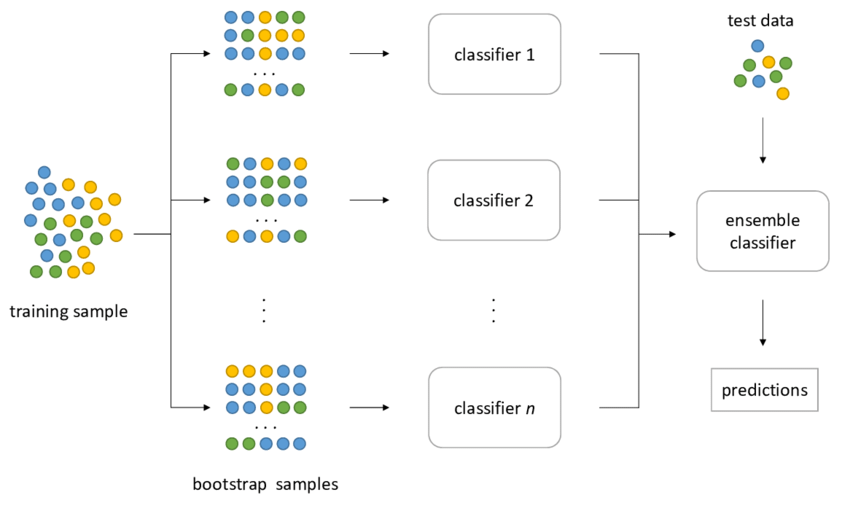

In [35]:
xgb = XGBClassifier(objective='binary:logistic', random_state=10)

cv_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [1.0],
    'gamma': [0.3, 0.4, 0.5],
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = RandomizedSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall', n_iter=100, random_state = 11)

In [36]:
xgb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=10, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [1.0],
                                        'gamma': [0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.8, 0.9]},
                   random_state=11, refit='recall',
                   scoring={'accuracy', 'precision', 'recall', 'f1'})

In [37]:
xgb_cv.best_score_

0.9996033683182817

In [38]:
xgb_cv.best_params_

{'subsample': 0.9,
 'n_estimators': 50,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 0.3,
 'colsample_bytree': 1.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

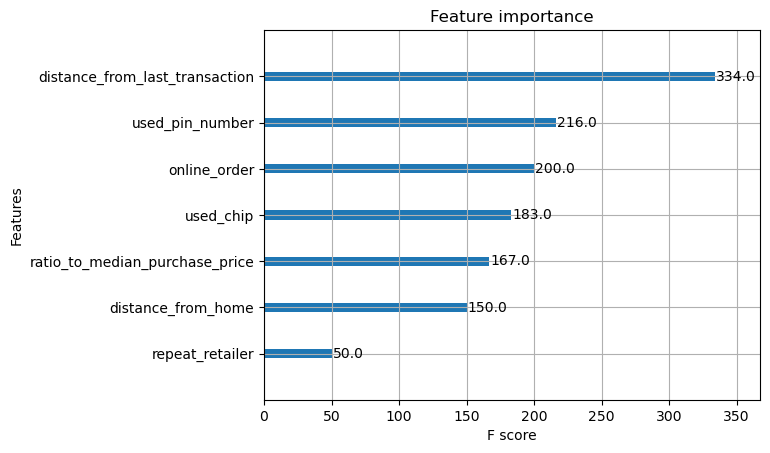

In [39]:
plot_importance(xgb_cv.best_estimator_)

Here the situation is somewhat different from the decision tree, since here the most important parameter is the distance from the last transaction, which was 3rd in importance in the decision tree, you can also observe the important role of used_pin_number and online_order. The importance of the indicators is more uniform than in the decision tree

In [40]:
y_xgb = xgb_cv.predict(X_test)

In [41]:
xgb_scores = get_test_scores('XGBoost', y_xgb, y_test)

results = pd.concat([results, xgb_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359
0,Naive Bayes,0.907433,0.963205,0.934488,0.930882
0,Decision Tree,0.999725,0.999863,0.999794,0.999789
0,XGBoost,0.993360,0.999634,0.996487,0.996393


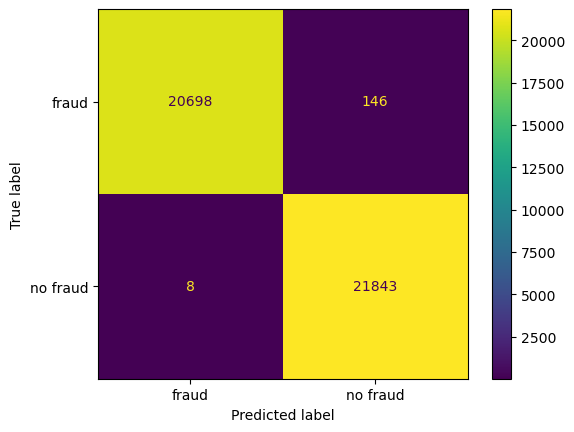

In [42]:
cm = confusion_matrix(y_test, y_xgb, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fraud', 'no fraud'])
disp.plot();

Analyzing the matrix, we can see that this model misses 8 fraudulent transactions

# Random Forest

Random Forest is an ensemble of machine learning models used for classification and regression tasks. It consists of several decision trees, where each tree calculates predictions independently and the result is determined by voting or averaging, respectively.

The basic idea is to create multiple random decision trees, where choosing random subsets of features and examples helps reduce overtraining. Each tree is trained on different data, and the result of their ensemble allows to obtain more accurate and stable predictions.

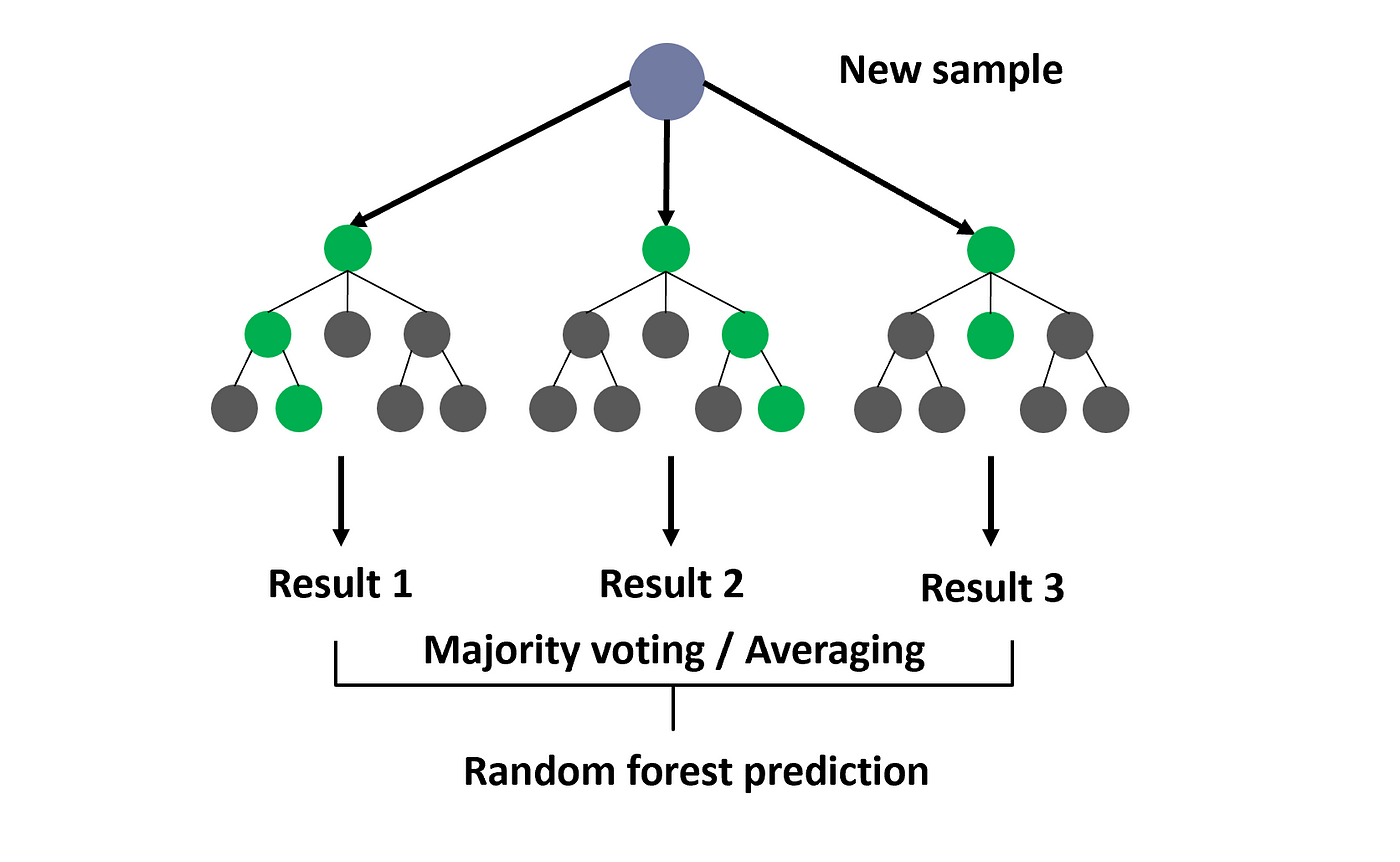

The procedure is similar to previous models

In [43]:
rf = RandomForestClassifier(max_samples=None, random_state=42)

cv_params = {'min_samples_leaf': [1, 2, 3, 5],
             'n_estimators': [10, 20, 30, 50],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [44]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [10, 20, 30, 50]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

In [45]:
rf_cv.best_score_

0.9999847449353185

In [46]:
rf_cv.best_params_

{'min_samples_leaf': 1, 'n_estimators': 50}

In [47]:
y_rf = rf_cv.predict(X_test)

In [48]:
rf_scores = get_test_scores('Random Forest', y_rf, y_test)

results = pd.concat([results, rf_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359
0,Naive Bayes,0.907433,0.963205,0.934488,0.930882
0,Decision Tree,0.999725,0.999863,0.999794,0.999789
0,XGBoost,0.993360,0.999634,0.996487,0.996393
0,Random Forest,0.999908,0.999863,0.999886,0.999883


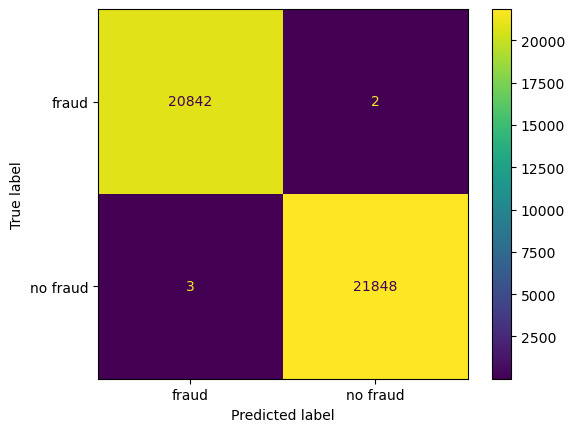

In [49]:
cm = confusion_matrix(y_test, y_rf, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['fraud', 'no fraud'])
disp.plot();

As you can see from the results, the model showed the same result in recall as the decision tree, but better results in other evaluations, so it is our best model

# Outliers

We will try to improve models that are sensitive to outliers

Our first models are sensitive, so we will now try to see if they will perform better if we do something with the outliers. We will write 2 functions, one will remove the outliers, the other will replace them with the 1st or 3rd quartile

In [66]:
def remove_outliers(df, column_name):
    Q1 = np.percentile(df[column_name], 25)
    Q3 = np.percentile(df[column_name], 75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_cleaned

In [67]:
def replace_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    column = np.where(column < lower_bound, Q1, column)
    column = np.where(column > upper_bound, Q3, column)
    
    return column

Next, we apply the functions to our dataset

In [68]:
df_rep = df_ds.copy()
df_rep['distance_from_home'] = replace_outliers(df_rep['distance_from_home'])
df_rep['distance_from_last_transaction'] = replace_outliers(df_rep['distance_from_last_transaction'])
df_rep['ratio_to_median_purchase_price'] = replace_outliers(df_rep['ratio_to_median_purchase_price'])

df_removed = remove_outliers(df_ds, 'distance_from_home')
df_removed = remove_outliers(df_removed, 'distance_from_last_transaction')
df_removed = remove_outliers(df_removed, 'ratio_to_median_purchase_price')

Next, I propose to look at the distribution of data in three datasets:
- original (downsample)
- removed outliers
- replaced outliers

### Original:

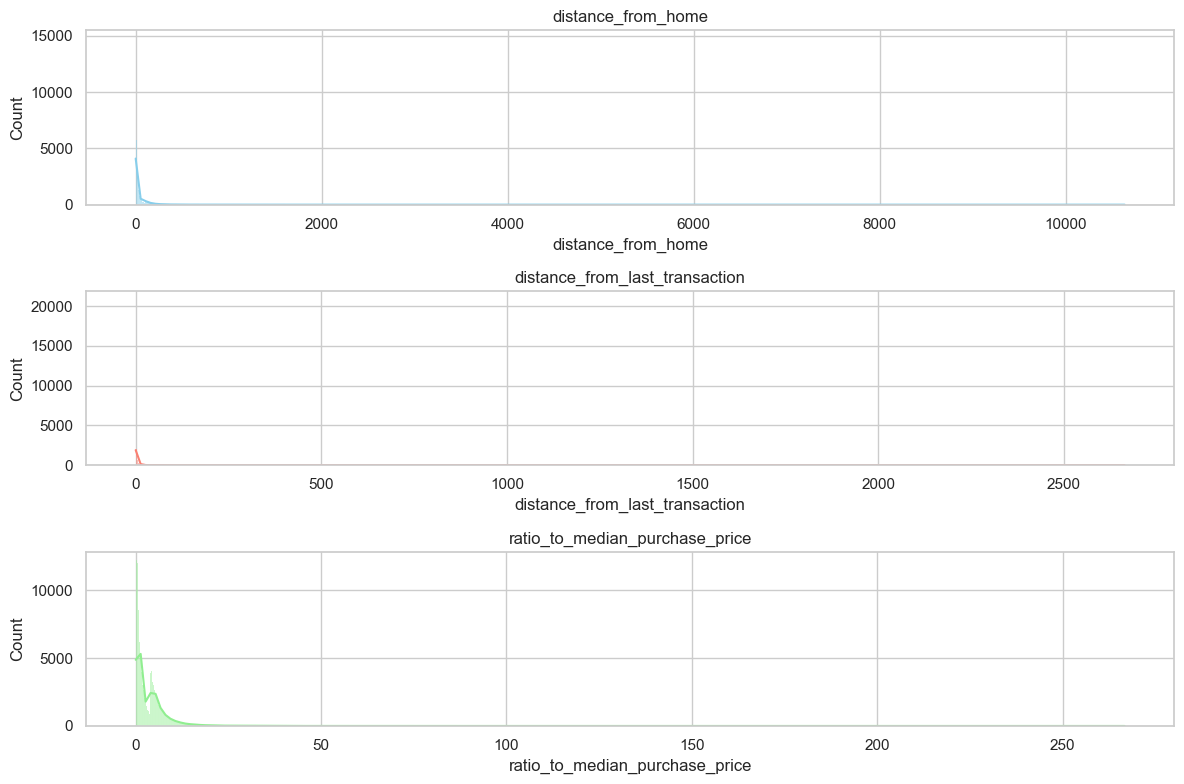

In [64]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

sns.histplot(data=df_ds['distance_from_home'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('distance_from_home')

sns.histplot(data=df_ds['distance_from_last_transaction'], ax=axes[1], color='salmon', kde=True)
axes[1].set_title('distance_from_last_transaction')

sns.histplot(data=df_ds['ratio_to_median_purchase_price'], ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title('ratio_to_median_purchase_price')

plt.tight_layout()

plt.show()

It is difficult to see anything adequate here, as large outliers distort the image

### Removed:

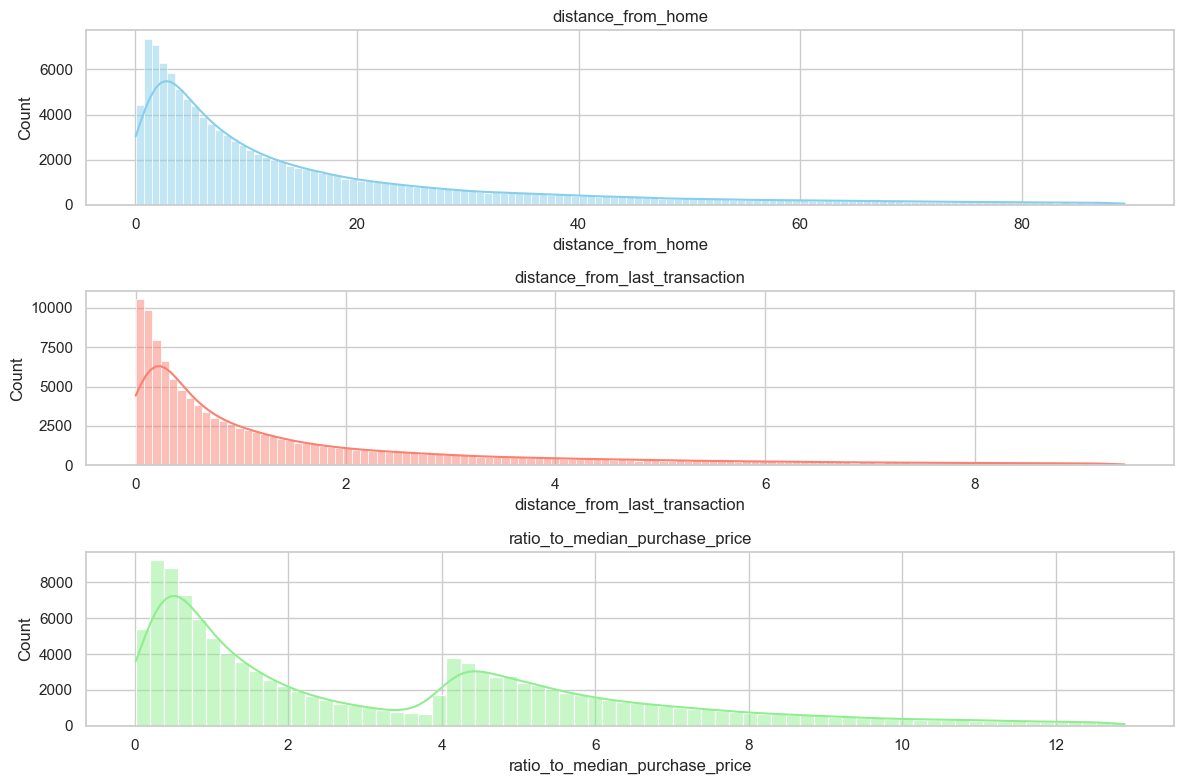

In [62]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

sns.histplot(data=df_removed['distance_from_home'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('distance_from_home')

sns.histplot(data=df_removed['distance_from_last_transaction'], ax=axes[1], color='salmon', kde=True)
axes[1].set_title('distance_from_last_transaction')

sns.histplot(data=df_removed['ratio_to_median_purchase_price'], ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title('ratio_to_median_purchase_price')

plt.tight_layout()

plt.show()

Here, as you can see, there is a much better distribution of the data, thanks to the removed outliers.
But one downside is that we only kept 70% of the downsampled data and 12% of the original data

In [80]:
print(len(df_removed)/len(df_ds)*100)

print(len(df_removed)/len(df)*100)

69.96960949073939
11.9492


### Replaced:

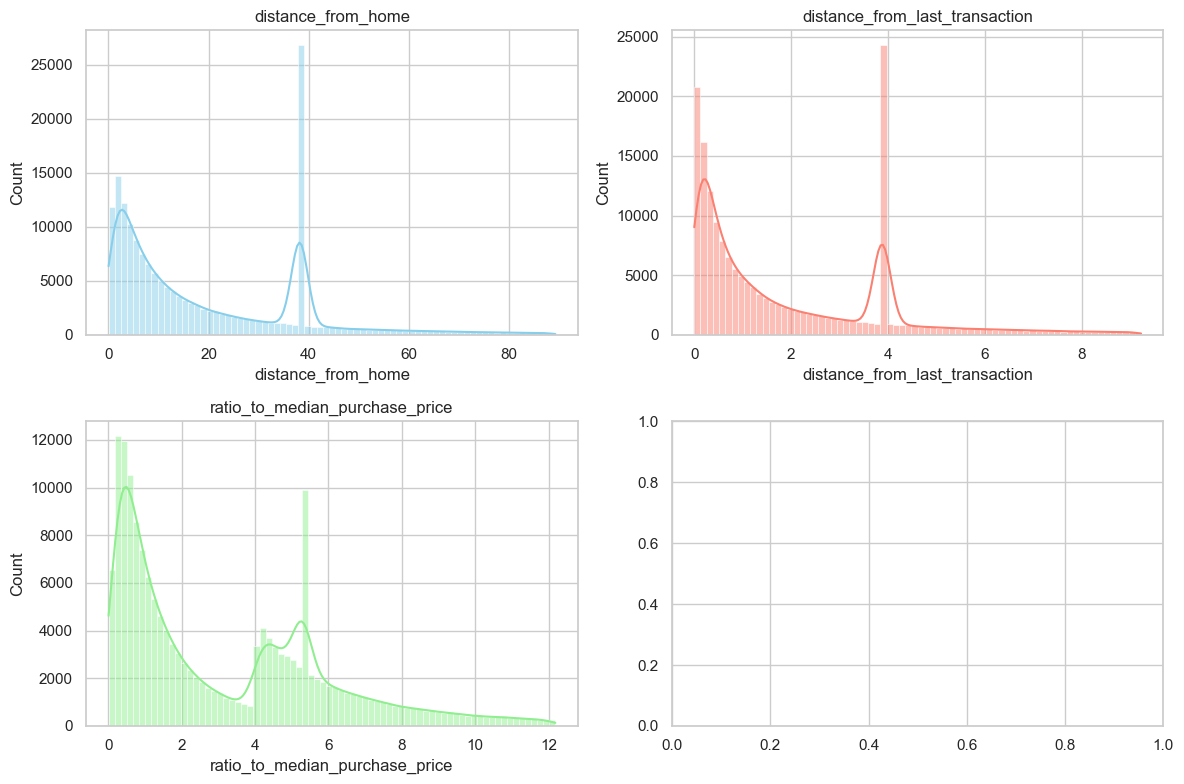

In [77]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

sns.histplot(data=df_replaced['distance_from_home'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('distance_from_home')

sns.histplot(data=df_replaced['distance_from_last_transaction'], ax=axes[1], color='salmon', kde=True)
axes[1].set_title('distance_from_last_transaction')

sns.histplot(data=df_replaced['ratio_to_median_purchase_price'], ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title('ratio_to_median_purchase_price')

plt.tight_layout()

plt.show()

From this you can already understand that the replacement works a little worse, but let's check how the models work

In [55]:
X3 = df_removed.drop(columns=['fraud'])
y3 = df_removed['fraud']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify=y3,
                                              test_size=0.25, random_state=12)

X4 = df_rep.drop(columns=['fraud'])
y4 = df_rep['fraud']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, stratify=y4,
                                              test_size=0.25, random_state=12)

In [56]:
lr3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000).fit(X3_train,y3_train)
lr4 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000).fit(X4_train,y4_train)

nb2 = naive_bayes.GaussianNB()
nb3 = naive_bayes.GaussianNB()

In [57]:
y_pred_lr3 = lr3.predict(X3_test)
y_pred_lr4 = lr4.predict(X4_test)

nb2.fit(X3_train, y3_train)
nb3.fit(X4_train, y4_train)

y_nb2 = nb2.predict(X3_test)
y_nb3 = nb3.predict(X4_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [84]:
print('Removed Logistic Regression Scores:')
print("Accuracy:", "%.6f" % accuracy_score(y3_test, y_pred_lr3))
print("Precision:", "%.6f" % precision_score(y3_test, y_pred_lr3))
print("Recall:", "%.6f" % recall_score(y3_test, y_pred_lr3))
print("F1 Score:", "%.6f" % f1_score(y3_test, y_pred_lr3))

print('\nReplaced Logistic Regression Scores:')
print("Accuracy:", "%.6f" % accuracy_score(y4_test, y_pred_lr4))
print("Precision:", "%.6f" % precision_score(y4_test, y_pred_lr4))
print("Recall:", "%.6f" % recall_score(y4_test, y_pred_lr4))
print("F1 Score:", "%.6f" % f1_score(y4_test, y_pred_lr4))

Removed Logistic Regression Scores:
Accuracy: 0.975028
Precision: 0.956639
Recall: 0.982094
F1 Score: 0.969199

Replaced Logistic Regression Scores:
Accuracy: 0.857337
Precision: 0.870336
Recall: 0.847513
F1 Score: 0.858773


Consider, for example, the results for logistic regression. The obtained results for the logistic regression show a complete superiority of the deleted data over the replaced ones

Next, we will add the results to the general table and compare them with other models

In [59]:
lr3_scores = get_test_scores('LR_Removed_Outliers', y_pred_lr3, y3_test)
lr4_scores = get_test_scores('LR_Replaced_Outliers', y_pred_lr4, y4_test)
nb2_scores = get_test_scores('NB_Removed_Outliers', y_nb2, y3_test)
nb3_scores = get_test_scores('NB_Replaced_Outliers', y_nb3, y4_test)

results = pd.concat([results, lr3_scores], axis=0)
results = pd.concat([results, lr4_scores], axis=0)
results = pd.concat([results, nb2_scores], axis=0)
results = pd.concat([results, nb3_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Logistic Regression,0.934948,0.953732,0.944247,0.942359
0,Naive Bayes,0.907433,0.963205,0.934488,0.930882
0,Decision Tree,0.999725,0.999863,0.999794,0.999789
0,XGBoost,0.993360,0.999634,0.996487,0.996393
0,Random Forest,0.999908,0.999863,0.999886,0.999883
0,LR_Removed_Outliers,0.956639,0.982094,0.969199,0.975028
0,LR_Replaced_Outliers,0.870336,0.847513,0.858773,0.857337
0,NB_Removed_Outliers,0.531860,0.984771,0.690689,0.647140
0,NB_Replaced_Outliers,0.639427,0.959681,0.767485,0.702401


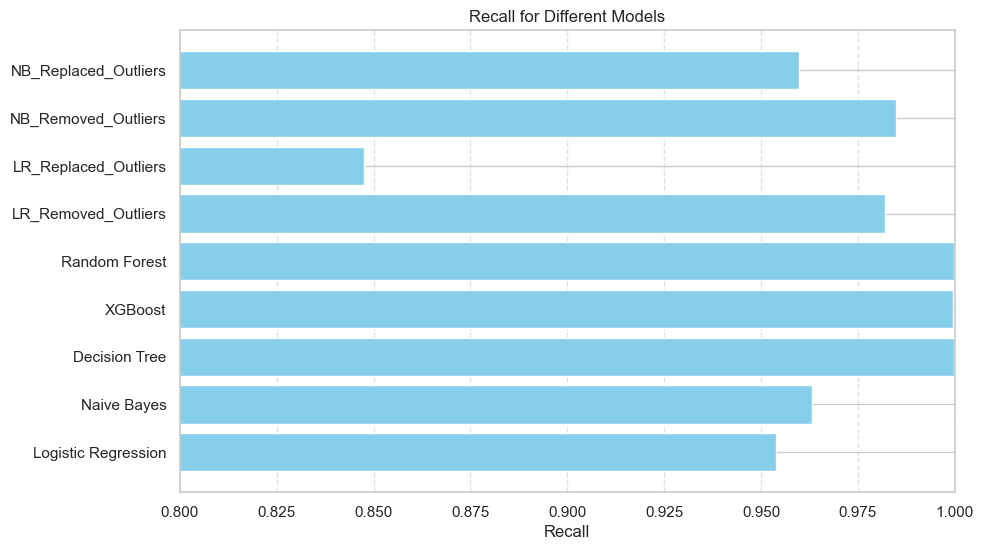

In [92]:
plt.figure(figsize=(10, 6))
plt.barh(results['model'], results['recall'], color='skyblue')
plt.xlabel('Recall')
plt.title('Recall for Different Models')
plt.xlim(0.8, 1)  # Задаємо межі по осі x від 0.8 до 1
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Відображення діаграми
plt.show()

From the results, you can see that we have significantly improved the quality of our two models by removing outliers. All our models performed very well, but the decision tree and random forest perform almost perfectly, so you can safely use these models to detect fraud in such data.